In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import sys, os, time, argparse, glob
from desitarget.targetmask import desi_mask

In [2]:
def flux_to_mag(flux):
    mag = 22.5 - 2.5*np.log10(flux)
    return mag

In [3]:
def cut(ramin, ramax, decmin, decmax, catalog):
    
    mask = np.logical_and(catalog['RA'] >= ramin, catalog['RA'] <= ramax)
    mask &= np.logical_and(catalog['DEC'] >= decmin, catalog['DEC'] <= decmax)
    cat = catalog[mask]
    #print(len(cat))
    
    return cat

In [4]:
def get_mag_decals(df):
    
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    print('FLUX_[R,G,Z]>=0:',len(df))
    rmag =  flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
    
    return gmag, rmag, zmag

In [5]:
class Point:

    def __init__(self, xcoord=0, ycoord=0):
        self.x = xcoord
        self.y = ycoord

class Rectangle:
    def __init__(self, bottom_left, top_right, colour):
        self.bottom_left = bottom_left
        self.top_right = top_right
        self.colour = colour

    def intersects(self, other):
        return not (self.top_right.x <= other.bottom_left.x or self.bottom_left.x >= other.top_right.x or self.top_right.y <= other.bottom_left.y or self.bottom_left.y >= other.top_right.y)
    
    def plot(self, other):
        fig, ax = plt.subplots(figsize=(15,8))
        rect = patches.Rectangle((self.bottom_left.x,self.bottom_left.y), abs(self.top_right.x - self.bottom_left.x), abs(self.top_right.y - self.bottom_left.y),linewidth=1.5, alpha=0.5, color='r')
        rect2 = patches.Rectangle((other.bottom_left.x,other.bottom_left.y), abs(other.top_right.x - other.bottom_left.x), abs(other.top_right.y - other.bottom_left.y),linewidth=1.5, alpha=0.5, color='blue')
        ax.add_patch(rect)
        ax.add_patch(rect2)
        xlims = np.array([self.bottom_left.x, self.top_right.x, other.bottom_left.x, other.top_right.x])
        ylims = np.array([self.bottom_left.y, self.top_right.y, other.bottom_left.y, other.top_right.y])
        ax.set_xlim(xlims.min()-1, xlims.max()+1)
        ax.set_ylim(ylims.min()-1, ylims.max()+1)
        #plt.show()

In [6]:
def cut_sweeps(ramin, ramax, decmin, decmax, sweep_dir):
    
    cat1_paths = sorted(glob.glob(os.path.join(sweep_dir, '*.fits')))
    #cat = np.empty()
    j = 0
    
    for fileindex in range(len(cat1_paths)):
    #for fileindex in range(5):

        cat1_path = cat1_paths[fileindex]
        filename = cat1_path[-26:-5]
        brick = cat1_path[-20:-5]
        ra1min = float(brick[0:3])
        ra1max = float(brick[8:11])
        dec1min = float(brick[4:7])
        if brick[3]=='m':
            dec1min = -dec1min
        dec1max = float(brick[-3:])
        if brick[-4]=='m':
            dec1max = -dec1max
        
        r1=Rectangle(Point(ramin,decmin), Point(ramax, decmax), 'red')
        r2=Rectangle(Point(ra1min, dec1min), Point(ra1max, dec1max), 'blue')
        
        if not r1.intersects(r2):
            continue
        
        if j == 0:
            cat = fitsio.read(cat1_path)
            cat = cut(ramin, ramax, decmin, decmax, cat)
            print(filename, len(cat))
            j += 1
            continue
        
        name = fitsio.read(cat1_path)
        name = cut(ramin, ramax, decmin, decmax, name)
        print(filename, len(name))
        
        cat = np.concatenate((cat, name))
        j += 1
        
    print('Bricks that matched: %i' %(j))
    print('Sample region # objects: %i' %(len(cat)))
    
    return cat

In [13]:
def mag_hist_decals(df, BANDS, DEF, NAME):
    
    print('Full:',len(df))
    gmag, rmag, zmag = get_mag_decals(df)
    df = df[(df['FLUX_R'] > 0) & (df['FLUX_G'] > 0) & (df['FLUX_Z'] > 0)]
    mask_psf = df['TYPE'] == b'PSF '
    #mask_nopsf = df['TYPE'] != b'PSF '
    mask_rex = df['TYPE'] == b'REX '
    mask_dev = df['TYPE'] == b'DEV '
    mask_exp = df['TYPE'] == b'EXP '
    mask_comp = df['TYPE'] == b'COMP '
    
    bins = np.linspace(15, 28, 100)
    if BANDS == 'r':
        BAND = rmag
    if BANDS == 'g':
        BAND = gmag
    if BANDS == 'z':
        BAND = zmag

    plt.figure(figsize=(12, 7))
    
    if DEF == 'MAGS':
        plt.hist(BAND[(mask_rex)], bins=bins,label=r'%s, REX'%(BANDS), histtype='step', fill=False, linewidth=2.0)
        plt.hist(BAND[(mask_dev)], bins=bins,label=r'%s, DEV'%(BANDS), histtype='step', fill=False, linewidth=2.0)
        plt.hist(BAND[(mask_exp)], bins=bins,label=r'%s, EXP'%(BANDS), histtype='step', fill=False, linewidth=2.0)
        plt.hist(BAND[(mask_comp)], bins=bins,label=r'%s, COMP'%(BANDS), histtype='step', fill=False, linewidth=2.0)
        plt.hist(BAND[(mask_psf)], bins=bins,label=r'%s, PSF'%(BANDS), histtype='step', fill=False, linewidth=2.0)
        plt.hist(BAND, bins=bins,label=r'%s, All'%(BANDS), histtype='step', fill=False, linewidth=2.0, linestyle='--', color='black')
    
    if DEF == 'ALL':
        plt.hist(rmag, bins=bins,label=r'r, All', histtype='step', fill=False, linewidth=2.0, linestyle='-', color='red')
        plt.hist(gmag, bins=bins,label=r'g, All', histtype='step', fill=False, linewidth=2.0, linestyle='-', color='green')
        plt.hist(zmag, bins=bins,label=r'z, All', histtype='step', fill=False, linewidth=2.0, linestyle='-', color='blue')
    #plt.xlim(16, 25)
    #plt.ylim(0, 1e5)
    plt.title(NAME)
    plt.xlabel('mag')
    plt.legend()
    plt.grid()

### Loading DECaLS DR7 from TARGETS

In [7]:
columns0 = ['RA', 'DEC', 'TYPE', 'DESI_TARGET', 'BRIGHTSTARINBLOB', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R','MW_TRANSMISSION_Z']
cat0 = fitsio.read('targets-dr7.1-0.23.0.fits', columns=columns0)
cat0S = cut(200, 230, -2,5, cat0)
print('# Total target Objects:', len(cat0))
print('# target objects sample region:', len(cat0S))

# Objects: 72660205


Creating a sample region:

200 $\leq$ RA $\leq$ 230

-2 $\leq$ DEC $\leq$ +5

### Loading DECaLS DR7 from SWEEPS

In [11]:
sweep_dir = os.path.join('/global/project/projectdirs/cosmo/data/legacysurvey/','dr7', 'sweep', '7.1')
cat0Sw = cut_sweeps(200, 230, -2,5, sweep_dir)

sweep-200m005-210p000 1688738
sweep-200p000-210p005 4086987
sweep-210m005-220p000 1739258
sweep-210p000-220p005 4353884
sweep-220m005-230p000 2276054
sweep-220p000-230p005 4815436
Bricks that matched: 6
Sample region # objects: 18960357
# sweep objects sample region: 18960357


Full: 18960357
FLUX_[R,G,Z]>=0: 17775320


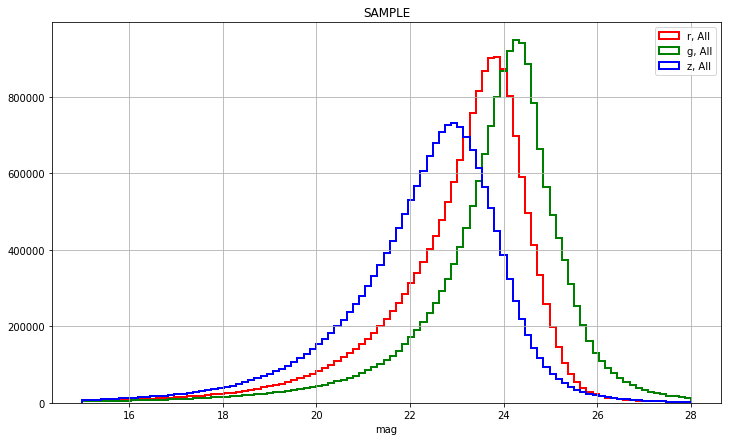

In [14]:
mag_hist_decals(cat0Sw, 'r', 'ALL', 'SAMPLE')

Full: 18960357
FLUX_[R,G,Z]>=0: 17775320


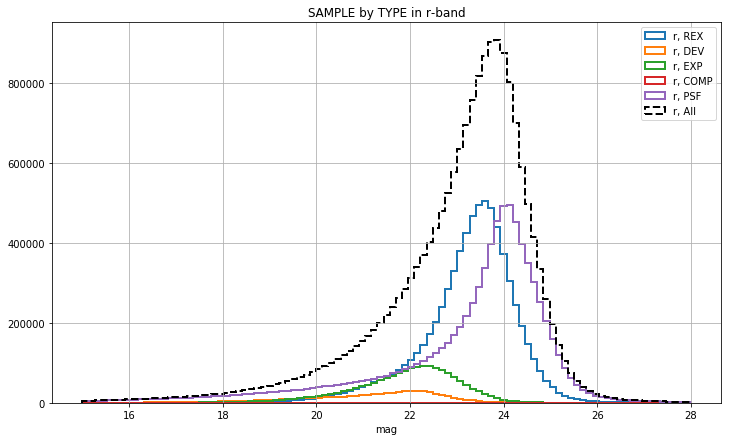

In [15]:
mag_hist_decals(cat0Sw, 'r', 'MAGS', 'SAMPLE by TYPE in r-band')

Full: 18960357
FLUX_[R,G,Z]>=0: 17775320


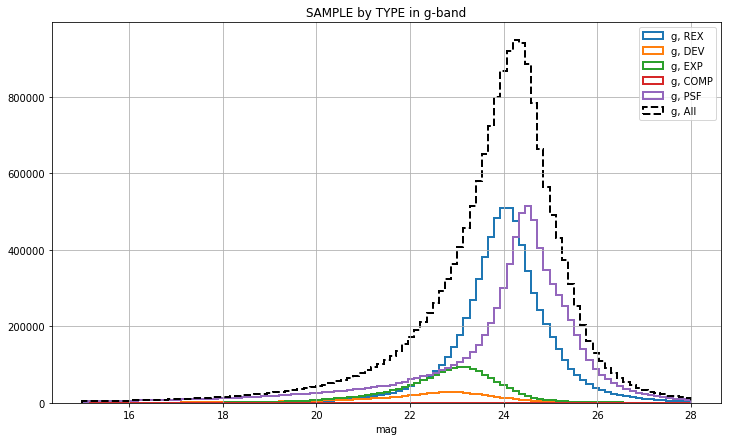

In [16]:
mag_hist_decals(cat0Sw, 'g', 'MAGS', 'SAMPLE by TYPE in g-band')

Full: 18960357
FLUX_[R,G,Z]>=0: 17775320


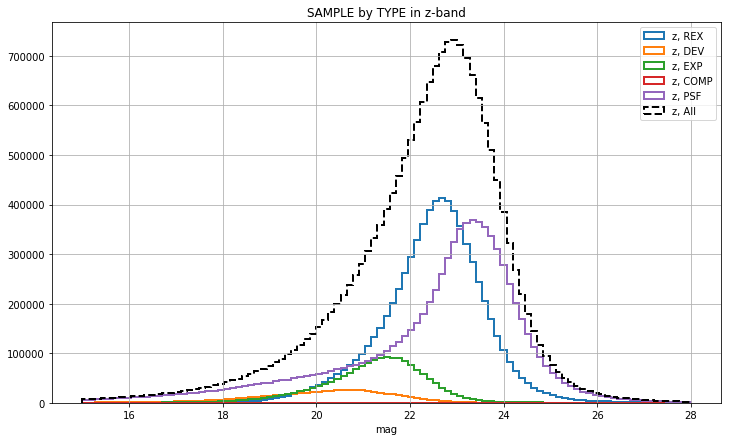

In [17]:
mag_hist_decals(cat0Sw, 'z', 'MAGS', 'SAMPLE by TYPE in z-band')